# set directory

In [ ]:
!rm -rf ~/.kaggle/kaggle.json # Remove the directory if it exists
!mkdir -p ~/.kaggle # This should create a directory named kaggle.json
!touch ~/.kaggle/kaggle.json  # Creates an empty file called kaggle.json


# Now place your credentials from kaggle.json into the file created in the previous step.
!cp kaggle.json ~/.kaggle/kaggle.json # Copy contents to the file
!chmod 600 ~/.kaggle/kaggle.json # Ensure correct permissions

# import data from kaggle

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# unzip data

In [ ]:
import zipfile
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    zip_ref.close()
    print("Done")

Done


# import libraries

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Normalization,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

# load data using keras

In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/data/train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180)
)
test_ds=keras.utils.image_dataset_from_directory(
    directory='/content/data/test',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


# check data shape

In [ ]:
for i in train_ds.take(1):
  print(i[0].shape)

(32, 180, 180, 3)


In [ ]:
for image,label in train_ds.take(1):
  print(image.shape)
  print(label.shape)

(32, 180, 180, 3)
(32,)


# Visulize data

In [ ]:
img=image/255.0

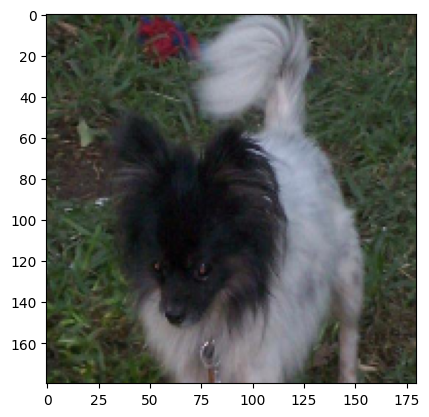

In [ ]:
plt.imshow(img[0])
plt.show()

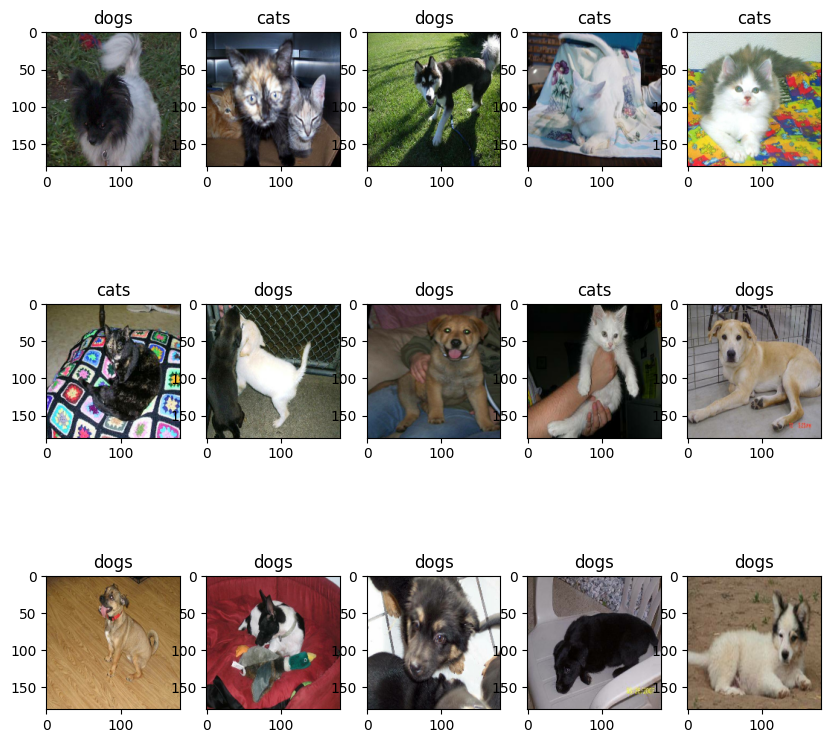

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,15):
  plt.subplot(3,5,i+1)
  plt.imshow(img[i])
  plt.title(train_ds.class_names[label[i]])

In [ ]:
for image,label in train_ds.take(5):
  print(image.shape)
  print(label.shape)

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [ ]:
img5=image/255.0

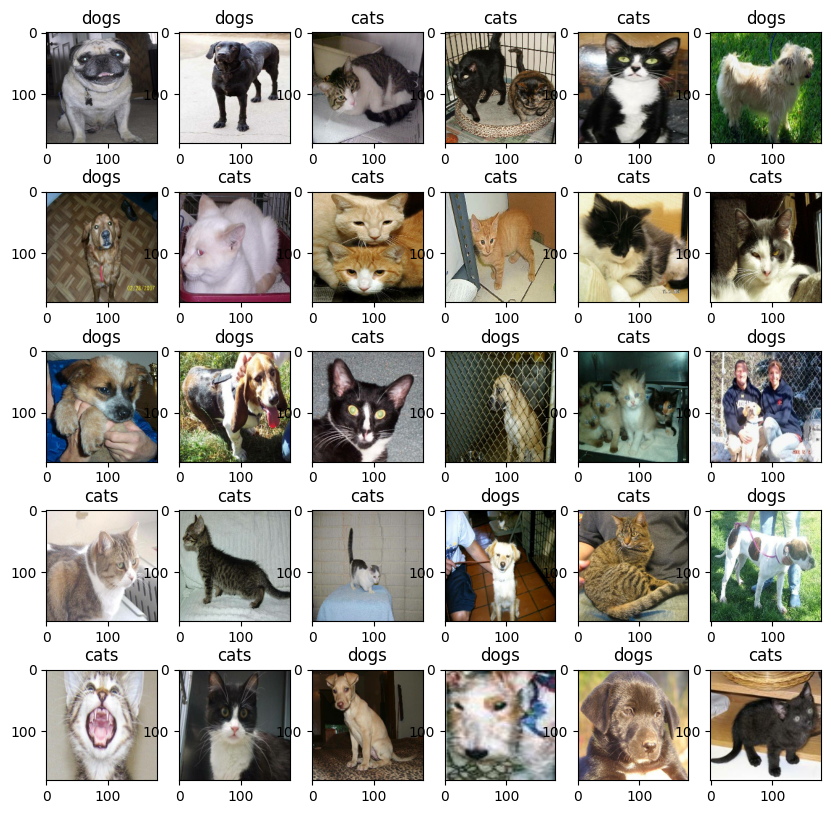

In [ ]:
plt.figure(figsize=(10,10))

for i in range(0,30):
  plt.subplot(5,6,i+1)
  plt.imshow(img5[i])
  plt.title(train_ds.class_names[label[i]])

In [ ]:
for image,label in test_ds.take(5):
  print(image.shape)
  print(label.shape)

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [ ]:
test_img=image/255.0

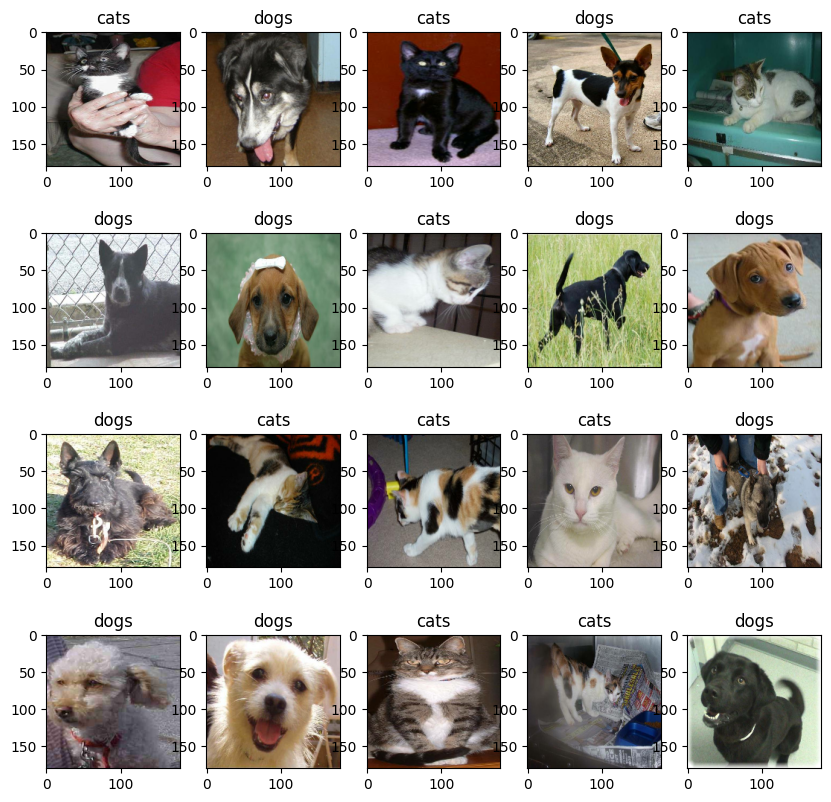

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(test_img[i])
  plt.title(train_ds.class_names[label[i]])

# Data augmentation

In [ ]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3
    ,zoom_range=0.3,
    horizontal_flip=True
    ,brightness_range=[0.5,1.5])


test_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_genrator=train_gen.flow_from_directory(
    directory='/content/data/train',
    target_size=(180,80),
    batch_size=32,
    class_mode='binary'
)
test_genrator=test_gen.flow_from_directory(
    directory='/content/data/test',
    target_size=(180,180),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# normalize data

In [ ]:
#normalize the data
import tensorflow as tf
def process(image,label):
  image=tf.cast(image/255.0,tf.float32)
  return image,label
  train_ds=train_genrator.map(process)
  test_ds=test_genrator.map(process)

# Model building

In [ ]:
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,3),padding='same'))

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,3),padding='same'))

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,3),padding='same'))

model.add(Flatten())


model.add(Dense(128,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(230,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))



# architcture of our model


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 58, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 87, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 44, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 42, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 42, 18, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 21, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4032)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         516,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 230)                 │          29,670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 230)                 │             920 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 230)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 567,333 (2.16 MB)

 Trainable params: 566,425 (2.16 MB)

 Non-trainable params: 908 (3.55 KB)

In [ ]:
model.get_weights()

[array([[[[ 8.38629156e-02, -5.12105674e-02,  1.25999168e-01,
            1.52351558e-02, -1.03766195e-01,  1.55586451e-02,
            9.63082612e-02, -9.82832536e-02, -9.13100839e-02,
            7.81780332e-02,  1.29848257e-01, -9.21312869e-02,
           -4.89762947e-02, -1.66226625e-02,  1.28013492e-02,
           -1.92474201e-02,  7.31110573e-04,  1.14763394e-01,
           -6.06543422e-02, -1.03300989e-01,  8.11335891e-02,
           -7.76498765e-02, -3.98905948e-02, -5.26281148e-02,
            4.89147305e-02,  7.87751973e-02, -8.17580521e-02,
            4.74433899e-02,  1.25316426e-01, -2.73248106e-02,
           -9.39772874e-02,  4.44972515e-02],
          [ 9.64127481e-02,  8.87122005e-02,  8.72382969e-02,
           -5.04221022e-02,  5.05356640e-02,  5.56717217e-02,
           -6.36808649e-02,  9.45898741e-02,  3.83204818e-02,
           -6.24571294e-02,  8.30046535e-02,  1.13305196e-01,
            4.52410579e-02,  9.90221649e-02,  1.31210312e-01,
            1.16147101e-

# set parametors


In [ ]:
adam=Adam(learning_rate=0.01)
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# Early stop method

In [ ]:
early=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

# trainig model


In [ ]:
history=model.fit(train_ds,epochs=50,validation_data=test_ds,callbacks=[early])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5925 - loss: 21.9009 - val_accuracy: 0.6904 - val_loss: 1.3277
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.7363 - loss: 1.2304 - val_accuracy: 0.7764 - val_loss: 1.1903
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7717 - loss: 1.2110 - val_accuracy: 0.7738 - val_loss: 1.2653
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7880 - loss: 1.2841 - val_accuracy: 0.7554 - val_loss: 1.4363
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8016 - loss: 1.3358 - val_accuracy: 0.7878 - val_loss: 1.1983
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - accuracy: 0.8129 - loss: 1.3012 - val_accuracy: 0.7998 - val_loss: 1.1607
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.8278 - loss: 1.2556 - val_accuracy: 0.6774 - val_loss: 1.5632
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.8425 - loss: 1.1550 -

# ploting accuracy

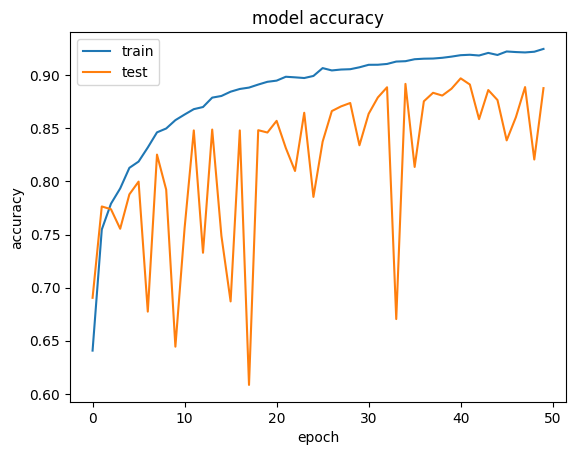

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plot loss

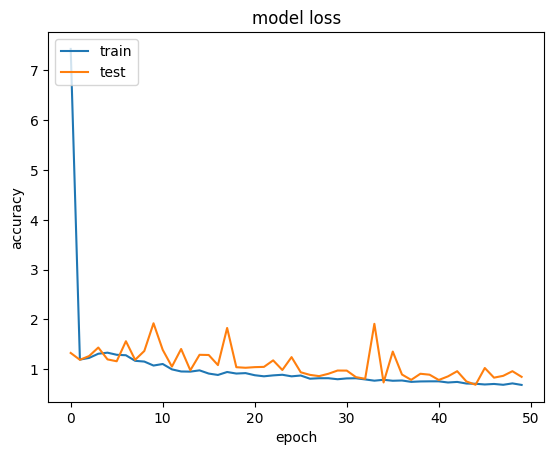

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')